# Model Baseline
Intrucciones: 
una vez realizado el EDA, deberá proceder con el desarrollo del modelo de
clasificación. Para esto, deberá utilizar un modelo de Regresión Logísitica e incluir lo
siguiente:

### A) análisis general de features disponibles.
Cargar dataset en su estado original y hacer un análisis general de features disponibles.

In [1]:
#cargar data orignial
#hacer EDA base sobre la data.

### B) Modelo Baseline
Con todas las features que sean a primera impresión utilizables realizar un Modelo
Baseline y evaluar su rendimiento. Utilizar matriz de confusión, accuracy,
precision, recall y KS. Esta será la “vara” que iteraciones futuras del modelo
tendrán que superar.

In [2]:
# Utilizar matriz de confusión, accuracy, precision, recall y KS. 

In [4]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# GamesWCategoricas
fileID = '1jZZvMTUfZ1wmrBJ3f9pJBEKmYEKaBhzl'
url = f"https://drive.google.com/uc?id={fileID}"


# Games
# fileID = '1KeyIoSqeDSD30FEPOB9Y-OS5SCvQcAfR'
# url = f"https://drive.google.com/uc?id={fileID}"

In [5]:
output = "gamesWcategoricas.csv"  # Nombre del archivo local donde se guardará
gdown.download(url, output, quiet=False)

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1jZZvMTUfZ1wmrBJ3f9pJBEKmYEKaBhzl
From (redirected): https://drive.google.com/uc?id=1jZZvMTUfZ1wmrBJ3f9pJBEKmYEKaBhzl&confirm=t&uuid=3d97154c-0ee5-4d46-b8cc-bf7b4b01fc1e
To: c:\Users\javic\OneDrive\Documentos\GitHub\ProyectoDataScience\Modelo\gamesWcategoricas.csv
100%|██████████| 468M/468M [00:16<00:00, 28.1MB/s] 
C:\Users\javic\AppData\Local\Temp\ipykernel_8044\1306599052.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output)


In [7]:
# 1. Cargar datos limpios
# Asumimos que df_clean es tu DataFrame procesado
X = df.drop(columns=['Estimated owners'])
y = df['Estimated owners']

In [8]:
# 2. Eliminar columnas residuales no numéricas (si existen)
non_numeric_cols = X.select_dtypes(exclude=np.number).columns
if not non_numeric_cols.empty:
    X = X.drop(columns=non_numeric_cols)

# Quedan solo variables categóricas binarias y numéricas

In [9]:
# 3. Split estratificado por percentil de owners
y_bin = (y > y.median()).astype(int)  # Para estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y_bin, random_state=42
)


In [10]:
# 4. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# 5. Modelado de regresión lineal
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [12]:
# 6. Predicciones y métricas
y_pred = model.predict(X_test_scaled)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")

R²: 0.38
RMSE: 765,706


In [13]:
# 7. Métricas de clasificación (umbral = mediana)
median = y.median()
y_test_class = (y_test >= median).astype(int)
y_pred_class = (y_pred >= median).astype(int)

print("\nMétricas de Clasificación:")
print(f"Accuracy: {np.mean(y_test_class == y_pred_class):.2f}")
print(f"Precision: {np.sum((y_pred_class == 1) & (y_test_class == 1)) / np.sum(y_pred_class == 1):.2f}")
print(f"Recall: {np.sum((y_pred_class == 1) & (y_test_class == 1)) / np.sum(y_test_class == 1):.2f}")


Métricas de Clasificación:
Accuracy: 0.55
Precision: 0.89
Recall: 0.50


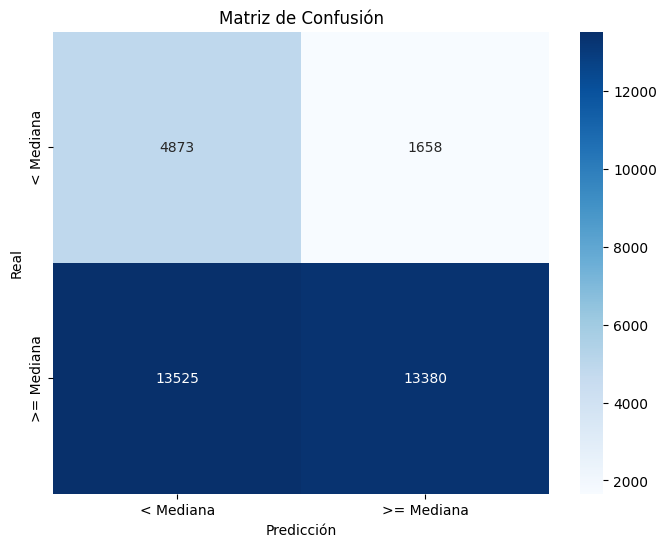

In [14]:
# 8. Matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_class, y_pred_class), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['< Mediana', '>= Mediana'], 
            yticklabels=['< Mediana', '>= Mediana'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

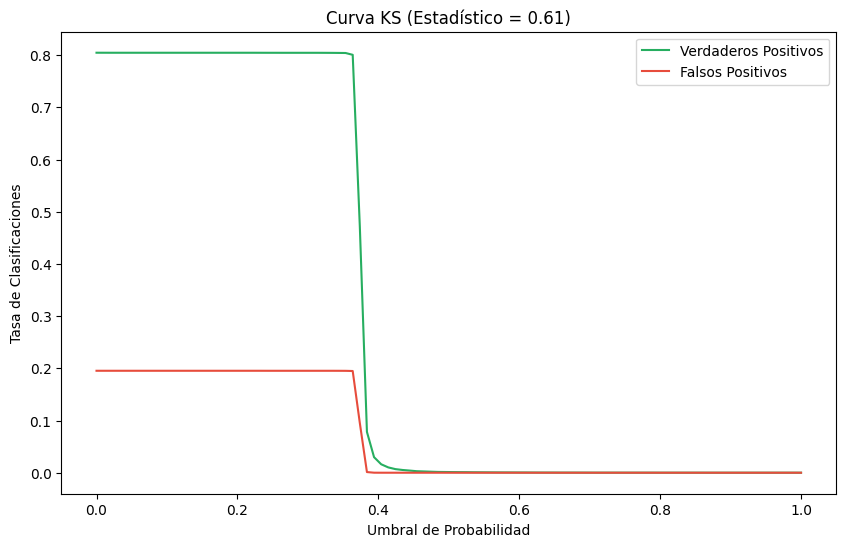

In [16]:
# 9. Curva KS
y_pred_prob = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())  # Escalar a 0-1

thresholds = np.linspace(0, 1, 100)
tp = [np.mean((y_pred_prob >= t) & (y_test_class == 1)) for t in thresholds]
fp = [np.mean((y_pred_prob >= t) & (y_test_class == 0)) for t in thresholds]
ks_value = np.max(np.abs(np.array(tp) - np.array(fp)))

plt.figure(figsize=(10,6))
plt.plot(thresholds, tp, label='Verdaderos Positivos', color='#27ae60')
plt.plot(thresholds, fp, label='Falsos Positivos', color='#e74c3c')
# plt.axvline(x=thresholds[np.argmax(tp - fp)], color='grey', linestyle='--')
plt.title(f'Curva KS (Estadístico = {ks_value:.2f})')
plt.xlabel('Umbral de Probabilidad')
plt.ylabel('Tasa de Clasificaciones')
plt.legend()
plt.show()

C:\Users\javic\AppData\Local\Temp\ipykernel_8044\2249931847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Variable',


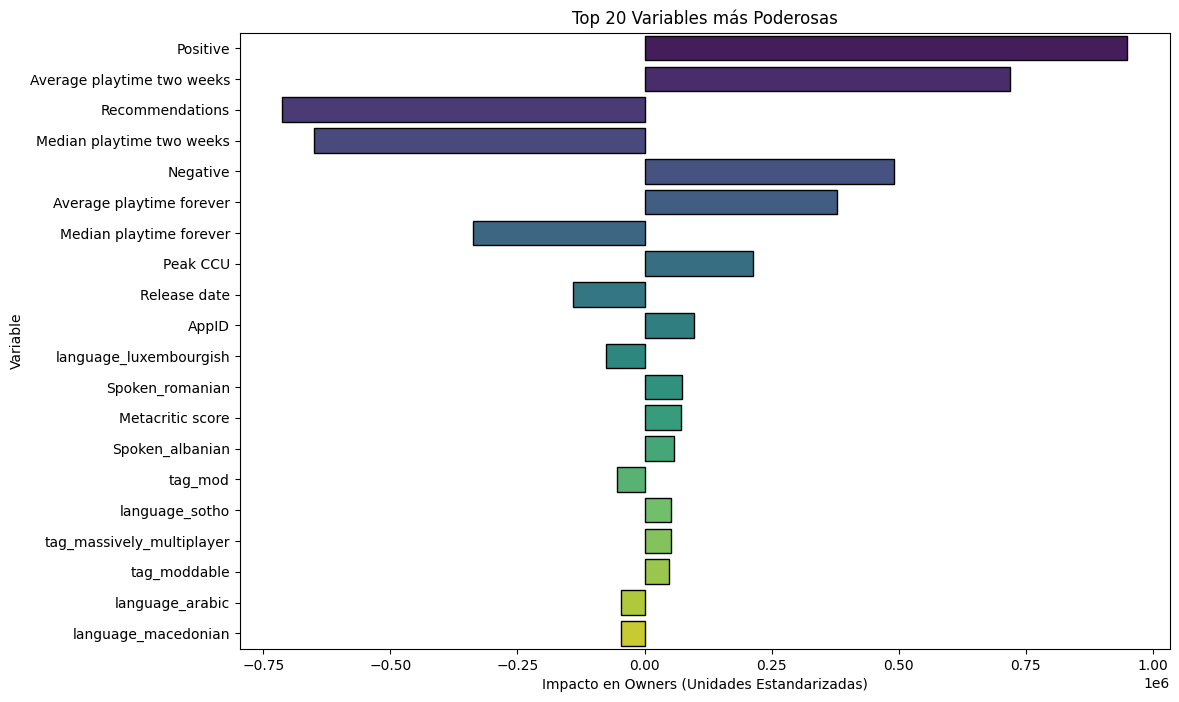

In [17]:
# 10. Importancia de variables
importance = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values('Coeficiente', key=abs, ascending=False).head(20)

plt.figure(figsize=(12,8))
sns.barplot(x='Coeficiente', y='Variable', 
            data=importance, palette='viridis',
            edgecolor='black')
plt.title('Top 20 Variables más Poderosas')
plt.xlabel('Impacto en Owners (Unidades Estandarizadas)')
plt.show()

- Revision de categorias rapida...

In [22]:
# Ver solo columnas categóricas (tipo object o category)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Columnas categóricas:")
print(categorical_cols)

Columnas categóricas:
['Name', 'About the game', 'Reviews', 'Header image', 'Website', 'Support url', 'Support email', 'Metacritic url', 'Notes', 'Developers', 'Publishers', 'Screenshots', 'Movies']


### C) Categoricas a numericas
Transformar variables categóricas a numéricas con el método adecuado según su
criterio, para poder incluirlas en el modelo.

In [23]:
# C) Categóricas a Numéricas

# Ya que muchas columnas como tags, categorías, géneros e idiomas ya están convertidas a variables binarias (dummies),
# solo confirmamos que las columnas puramente textuales innecesarias no estén incluidas

columnas_ignoradas = [
    'AppID', 'Name', 'About the game', 'Reviews', 'Header image',
    'Website', 'Support url', 'Support email', 'Metacritic url',
    'Notes', 'Screenshots', 'Movies'
]

# Eliminamos esas columnas si están presentes
X = X.drop(columns=[col for col in columnas_ignoradas if col in X.columns], errors='ignore')

# Además, si aún no fueron codificadas Developers y Publishers, las codificamos:
if 'Developers' in X.columns:
    X = pd.get_dummies(X, columns=['Developers'], drop_first=True)

if 'Publishers' in X.columns:
    X = pd.get_dummies(X, columns=['Publishers'], drop_first=True)


### D) Feature Engineering
Implementar Feature Engineering si alguna feature lo amerita, recordar lo visto en
las features del modelo de score crediticio.

In [24]:
# D) Feature Engineering

# 1. Crear variable con año de lanzamiento (si no se ha hecho ya)
if 'Release date' in X.columns:
    X['release_year'] = X['Release date']  # ya es numérico, pero puede servir analizarlo aparte

# 2. Agrupar precios por rangos
def agrupar_precio(precio):
    if precio == 0:
        return 'free'
    elif precio < 10:
        return 'low'
    elif precio < 30:
        return 'medium'
    else:
        return 'high'

if 'Price' in X.columns:
    X['price_range'] = X['Price'].apply(agrupar_precio)
    X = pd.get_dummies(X, columns=['price_range'], drop_first=True)

# Nota: asegur de eliminar la columna original 'Price' después si ya no la vamos a usar directamente

### E) Feature Selection
Implementar los siguientes métodos de Feature Selection y acompañado de su
criterio, decidir qué features incluir en el modelo y cuáles descartar.
i. Heatmap de correlación
ii. Feature importance por coeficientes
iii. WoE + IV

Despues de analizar la situación de la cantidad de features...lo mejor es filtrar por un umbral de importancia mínima, lo cual da una base más objetiva para elegir features relevantes.

In [ ]:

# E) Feature Selection

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Heatmap de correlación (solo primeras 25 columnas para que sea legible)
plt.figure(figsize=(16,10))
corr = X.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr.iloc[:25, :25], annot=False, cmap='coolwarm')
plt.title("Heatmap de correlación (primeras 25 features)")
plt.show()

# 2. Importancia de features por coeficientes del modelo base
from sklearn.linear_model import LogisticRegression

# Entrenamos modelo con los datos actuales (X ya procesado y escalado previamente)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Obtenemos importancia por coeficiente
importancia = pd.Series(model.coef_[0], index=X_train.columns)
importancia_abs = importancia.abs().sort_values(ascending=False)

# Mostramos las 15 features más relevantes
print("Top 15 features más importantes:")
display(importancia_abs.head(15))

# 3. WoE + IV (opcional)
# Podés dejar una celda markdown aclarando que este paso puede implementarse en etapas posteriores

In [ ]:
# 2. Importancia de features por coeficientes del modelo base (con umbral)

from sklearn.linear_model import LogisticRegression

# Entrenar el modelo con los datos escalados
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Importancia por coeficientes (valores absolutos)
importancia = pd.Series(model.coef_[0], index=X_train.columns)
importancia_abs = importancia.abs().sort_values(ascending=False)

# FILTRO: Mostrar solo features con importancia mayor a cierto umbral
umbral = 1.0
importantes = importancia_abs[importancia_abs > umbral]

print(f"Features con importancia > {umbral}:")
display(importantes)


### Resultados: 
En este modelo baseline vemos que...